### Try TemporalFusionTransformer
* Read: https://towardsdatascience.com/temporal-fusion-transformer-a-primer-on-deep-forecasting-in-python-4eb37f3f3594

In [1]:
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer

import warnings
warnings.filterwarnings('ignore')

# Used Yujie's cleaned version
DIR_BYID = '/media/user/12TB1/HanLi/GitHub/CMU11785-project/local_data/content/databyid'

ls_all_invest_ids = sorted([int(fn.split('.')[0]) for fn in os.listdir(os.path.join(DIR_BYID, 'target'))])

/home/user/anaconda3/envs/11785_project/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
f_cols = [f"f_{i}" for i in range(300)]
# Read a subset for testing
n = 3000
ls_dfs = []
for id in ls_all_invest_ids[:n]:
    df_f_id = pd.DataFrame(np.load(os.path.join(DIR_BYID, f'feats/{id}.npy')), columns=f_cols)
    df_t_id = pd.DataFrame(np.load(os.path.join(DIR_BYID, f'target/{id}.npy')), columns=['target'])
    df_f_id['investment_id'] = id
    ls_dfs.append(pd.concat([df_t_id, df_f_id], axis=1))

df = pd.concat(ls_dfs).reset_index().rename(columns={'index': 'time_id'})
df = df.sort_values(by=['time_id']) # sort by time before splitting
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)
# df_train, df_val = train_test_split(df_train, test_size=2/9, shuffle=False)

In [4]:
df_train

,time_id,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,investment_id
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1389580,0,0.000000,-2.483594,-1.016361,0.520959,-0.578885,-0.403828,-0.139673,-0.624265,-0.568195,...,-1.095620,-0.302857,0.819155,-1.060166,-0.516494,0.104928,-0.844595,-0.276643,-0.278406,1139
2486360,0,0.302411,0.064655,-0.514115,-0.793189,-0.087417,-0.266396,-0.031550,1.298448,0.737355,...,0.912726,-0.599186,0.819155,0.941183,-0.290695,1.296864,1.943773,-1.476265,0.086849,2038
3170780,0,-1.246223,0.597497,-0.262993,-1.993946,1.178246,5.582512,-0.309565,-1.760986,0.602612,...,0.912726,-1.072976,0.819155,0.941183,4.191910,1.296864,1.128417,1.279420,7.196918,2599
577060,0,0.276815,0.229707,-0.514115,0.080069,-0.584030,-0.393632,-1.250875,-1.674827,-1.789227,...,0.912726,1.000600,0.819155,-1.060166,-0.231865,-1.087009,-0.122143,0.962353,-0.526551,473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2631417,1097,1.443494,-1.212057,0.835765,0.390280,0.209423,-0.048850,-2.540634,1.098920,-1.215920,...,-0.757976,-0.069908,1.373311,-0.128573,0.122001,-2.997465,-1.964301,-2.285952,1.102100,2156
1785957,1097,-2.125934,1.288225,-2.608685,0.425745,-0.019027,-0.193957,-3.200137,-1.094699,0.222616,...,-0.733069,1.528895,-0.081540,0.319557,-0.132813,0.048358,-1.164411,-0.230242,-0.743838,1463
2286157,1097,-1.074061,-0.267248,1.038550,0.077865,-1.173909,2.789015,2.542614,1.255679,-0.281238,...,0.334841,1.336897,2.625973,-1.133870,7.173344,2.251664,-1.262915,-1.430725,3.151095,1873
1568797,1097,-0.027056,-0.682674,0.749004,2.251077,-0.185545,0.230120,-0.621255,-2.377464,-0.727309,...,1.516115,0.950391,-0.618045,-0.337303,1.343652,-0.187342,-0.695851,2.314882,0.932714,1285


### Create dataset and dataloaders

In [5]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss

# load data
# define dataset
max_encoder_length = 6
max_prediction_length = 1

# create validation and training dataset
batch_size = 128
max_prediction_length = 3
max_encoder_length = 24

# create the dataset from the pandas dataframe
train_dataset = TimeSeriesDataSet(
    df_train,
    group_ids=["investment_id"],
    target="target",
    time_idx="time_id",
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    # static_reals=[],
    time_varying_known_reals=["investment_id", "time_id"] + [f"f_{i}" for i in range(300)],
    time_varying_unknown_reals=['target'],
    target_normalizer=GroupNormalizer(
        groups=["investment_id"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

val_dataset = TimeSeriesDataSet.from_dataset(train_dataset, df_train, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


### Find optimal learning rate

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 226.9k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Finding best initial lr: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


suggested learning rate: 0.20892961308540398


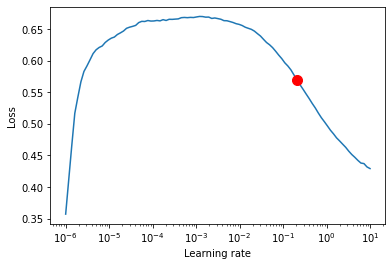

In [6]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

tft_model = TemporalFusionTransformer.from_dataset(
    train_dataset,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft_model.size()/1e3:.1f}k")


# find optimal learning rate
res = trainer.tuner.lr_find(
    tft_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

### Train Model

* Note: use tensorboard to check the logs: run ```tensorboard --logdir=<logging_folder>```
* To visualize tensorboard in Jupyter Notebook: 
    ```
    %reload_ext tensorboard
    %tensorboard --logdir=<logging_folder>
    ```

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tsbyq_wb (use `wandb login --relogin` to force relogin)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Number of parameters in network: 5874.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 4.3 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 16.6 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 2.5 M 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 5.5 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 263 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 263 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 263 

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:01<?, ?it/s]

AttributeError: 'Run' object has no attribute 'add_figure'

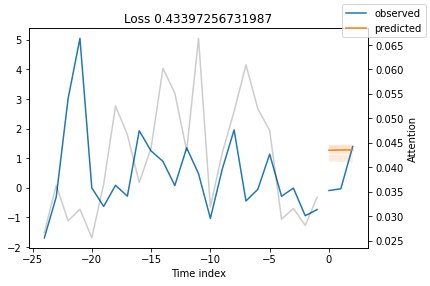

In [9]:
from pytorch_lightning.loggers import WandbLogger
DIR_LOGS = '/media/user/12TB1/HanLi/GitHub/CMU11785-project/logs' # Change this!
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
# logger = TensorBoardLogger(
#     save_dir=os.path.join(DIR_LOGS, "tft_test"),
#     name="lightning_logs"
# )

logger = WandbLogger(
    entity="11785_project",
    project="PyTorchForecasting_test",
    name='Test_421',
    log_model=True
)

trainer = pl.Trainer(
    max_epochs=20,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft_model = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=0.03,
    hidden_size=256,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=7,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft_model.size()/1e3:.1f}k")

# fit network
trainer.fit(
    tft_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [22]:
%reload_ext tensorboard
# %tensorboard --logdir=os.path.join(DIR_LOGS, 'tft_test/lightning_logs/version_0/events.out.tfevents.1650348368.srg-gpu.48045.1')
%tensorboard --logdir=/media/user/12TB1/HanLi/GitHub/CMU11785-project/logs/tft_test/lightning_logs/version_0/events.out.tfevents.1650348368.srg-gpu.48045.1

Reusing TensorBoard on port 6007 (pid 6863), started 0:03:16 ago. (Use '!kill 6863' to kill it.)